# SENTIMENT ANALYSIS NOTEBOOK

Dengan preprocessing, visualisasi, pelabelan, modelling, dan inference

## IMPORT LIBRARY

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [14]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

nltk.download('stopwords')

In [16]:
from nltk.corpus import stopwords

## LOAD DATASET

In [17]:
df = pd.read_csv('drive/MyDrive/Proyek Analisis Sentimen/data/dataset_ulasan_com_dafturn_mypertamina.csv')
print("Jumlah data:", len(df))
df.dropna(subset=['review'], inplace=True)

Jumlah data: 10000


## PREPROCESSING

In [18]:
stop_words = set(stopwords.words('indonesian'))

fungsi pembersih teks

In [19]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

terapkan pembersihan

In [20]:
print("Cleaning data...")
df['clean_review'] = df['review'].astype(str).apply(clean_text)

Cleaning data...


## WORD CLOUD

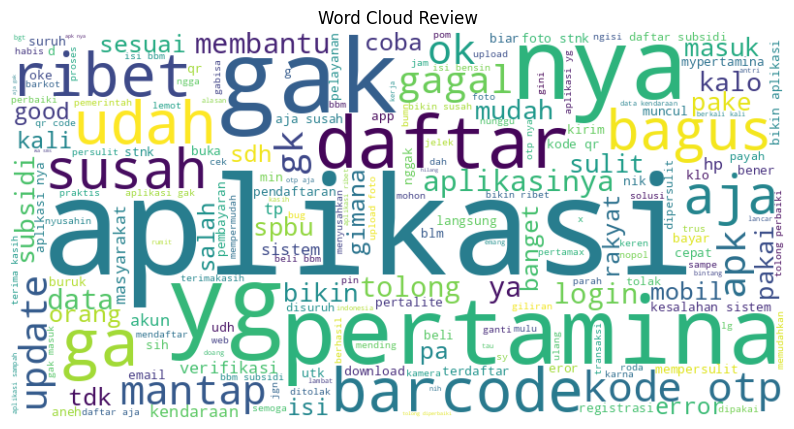

In [21]:
plt.figure(figsize=(10,6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['clean_review']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud Review")
plt.show()

## LABELING DENGAN LEXICON

In [22]:
def label_sentiment(row):
    if row['rating'] >= 4:
        return 'positif'
    elif row['rating'] == 3:
        return 'netral'
    else:
        return 'negatif'

df['sentiment'] = df.apply(label_sentiment, axis=1)

distribusi label

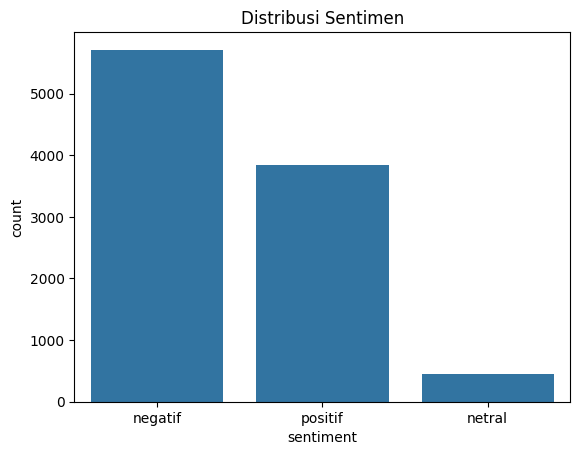

In [23]:
sns.countplot(data=df, x='sentiment')
plt.title("Distribusi Sentimen")
plt.show()

## HANDLING IMBALANCE

In [24]:
X = df['clean_review']
y = df['sentiment']

TF-IDF

In [25]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

SMOTE Oversampling

In [26]:
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X_tfidf, y)

## MODELLING

In [28]:
models = {
    'SVM': SVC(kernel='linear', C=1, probability=True),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

splits = [(0.8,0.2), (0.7,0.3)]

# Encode the target variable y_bal
label_encoder = LabelEncoder()
y_bal_encoded = label_encoder.fit_transform(y_bal)

for name, model in models.items():
    for train_ratio, test_ratio in splits:
        print(f"\nModel: {name} | Split: {int(train_ratio*100)}:{int(test_ratio*100)}")

        # Use the encoded y_bal_encoded for train/test split
        if name == 'XGBoost':
            X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal_encoded, test_size=test_ratio, random_state=42)
        else:
             X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=test_ratio, random_state=42)


        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
        print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))

        # Decode the predictions back to original labels for the classification report if it's XGBoost
        if name == 'XGBoost':
             y_pred_test_decoded = label_encoder.inverse_transform(y_pred_test)
             y_test_decoded = label_encoder.inverse_transform(y_test)
             print("Classification Report (Testing):\n", classification_report(y_test_decoded, y_pred_test_decoded))
        else:
            print("Classification Report (Testing):\n", classification_report(y_test, y_pred_test))



Model: SVM | Split: 80:20
Training Accuracy: 0.8592587188092806
Testing Accuracy: 0.7989495185293259
Classification Report (Testing):
               precision    recall  f1-score   support

     negatif       0.87      0.81      0.84      1159
      netral       0.69      0.88      0.78      1111
     positif       0.88      0.71      0.78      1157

    accuracy                           0.80      3427
   macro avg       0.81      0.80      0.80      3427
weighted avg       0.82      0.80      0.80      3427


Model: SVM | Split: 70:30
Training Accuracy: 0.8605019594763612
Testing Accuracy: 0.7904669260700389
Classification Report (Testing):
               precision    recall  f1-score   support

     negatif       0.87      0.79      0.83      1738
      netral       0.68      0.89      0.77      1678
     positif       0.88      0.69      0.77      1724

    accuracy                           0.79      5140
   macro avg       0.81      0.79      0.79      5140
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:49:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.8899022325988618
Testing Accuracy: 0.8327983659177123
Classification Report (Testing):
               precision    recall  f1-score   support

     negatif       0.85      0.83      0.84      1159
      netral       0.84      0.80      0.82      1111
     positif       0.81      0.86      0.84      1157

    accuracy                           0.83      3427
   macro avg       0.83      0.83      0.83      3427
weighted avg       0.83      0.83      0.83      3427


Model: XGBoost | Split: 70:30


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:50:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.8899357958809305
Testing Accuracy: 0.8346303501945526
Classification Report (Testing):
               precision    recall  f1-score   support

     negatif       0.86      0.81      0.84      1738
      netral       0.83      0.82      0.83      1678
     positif       0.81      0.87      0.84      1724

    accuracy                           0.83      5140
   macro avg       0.84      0.83      0.83      5140
weighted avg       0.84      0.83      0.83      5140



In [ ]:
## INFERENCE FUNCTION

In [29]:
def predict_sentiment(text, trained_model, vectorizer):
    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    pred = trained_model.predict(vectorized)[0]
    return pred

Contoh penggunaan

In [30]:
sample_texts = [
    "Aplikasinya bagus banget, sangat bermanfaat dan tentunya gratis hehe.. 😁🥰",
    "Aplikasinya jelek banget, error terus dan bikin kesel!",
    "Biasa aja sih, tidak terlalu buruk tapi juga tidak istimewa"
]

for txt in sample_texts:
    sentiment = predict_sentiment(txt, models['SVM'], tfidf)
    print(f"Teks: {txt}\nPrediksi Sentimen: {sentiment}\n")

Teks: Aplikasinya bagus banget, sangat bermanfaat dan tentunya gratis hehe.. 😁🥰
Prediksi Sentimen: positif

Teks: Aplikasinya jelek banget, error terus dan bikin kesel!
Prediksi Sentimen: negatif

Teks: Biasa aja sih, tidak terlalu buruk tapi juga tidak istimewa
Prediksi Sentimen: negatif

